# Lecture 8. Neural Networks

**How to train your neurons**

Joaquin Vanschoren

In [1]:
import os
import random
from numpy.random import seed
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.random import set_seed

#Trying to set all seeds
os.environ['PYTHONHASHSEED'] = str(0)
random.seed(0)
seed(0)
set_seed(0)
seed_value = 0

2023-05-25 21:21:06.584606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 21:21:06.607279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 21:21:06.927612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Neural networks in practice
* There are many practical courses on training neural nets. E.g.:
    * With TensorFlow: https://www.tensorflow.org/resources/learn-ml
    * With PyTorch: [fast.ai course](https://course.fast.ai/), https://pytorch.org/tutorials/
* Here, we'll use Keras, a general API for building neural networks
    * Default API for TensorFlow, also has backends for CNTK, Theano
* Focus on key design decisions, evaluation, and regularization
* Running example: Fashion-MNIST
    * 28x28 pixel images of 10 classes of fashion items

In [2]:
import openml as oml
import matplotlib.pyplot as plt
# Take some random examples
from random import randint

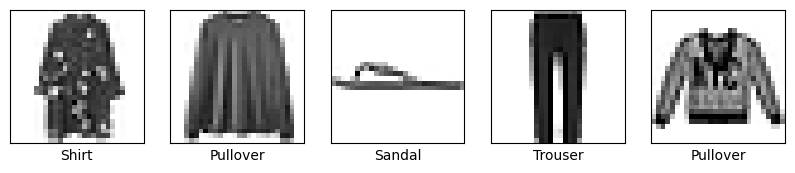

In [3]:
# Download FMINST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(40996)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)
fmnist_classes = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal",
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    n = randint(0, 70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("{}".format(fmnist_classes[y[n]]))
plt.show();

### Building the network
* We first build a simple sequential model (no branches)
* Input layer ('input_shape'): a flat vector of 28*28=784 nodes
    * We'll see how to properly deal with images later
* Two dense hidden layers: 512 nodes each, ReLU activation
    * Glorot weight initialization is applied by default
* Output layer: 10 nodes (for 10 classes) and softmax activation

``` python
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
```

In [4]:
from tensorflow.keras import initializers
from keras import models, layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))

2023-05-25 21:21:08.164008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 21:21:08.175549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 21:21:08.175582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 21:21:08.179031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-25 21:21:08.179065: I tensorflow/compile

#### Model summary
- Lots of parameters (weights and biases) to learn!
    - hidden layer 1 : (28 * 28 + 1) * 512 = 401920
    - hidden layer 2 : (512 + 1) * 512 = 262656
    - output layer: (512 + 1) * 10 = 5130
    
``` python
network.summary()
```

In [5]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Choosing loss, optimizer, metrics
* __Loss function__
    - Cross-entropy (log loss) for multi-class classification ($y_{true}$ is one-hot encoded)
    - Use binary crossentropy for binary problems (single output node) 
    - Use sparse categorical crossentropy if $y_{true}$ is label-encoded (1,2,3,...)
* __Optimizer__
    - Any of the optimizers we discussed before. RMSprop usually works well.
* __Metrics__ 
    - To monitor performance during training and testing, e.g. accuracy
    
``` python
# Shorthand
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# Detailed
network.compile(loss=CategoricalCrossentropy(label_smoothing=0.01),
                optimizer=RMSprop(learning_rate=0.001, momentum=0.0)
                metrics=[Accuracy()])
```

In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Preprocessing: Normalization, Reshaping, Encoding 
* Always normalize (standardize or min-max) the inputs. Mean should be close to 0.
    - Avoid that some inputs overpower others
    - Speed up convergence 
        - Gradients of activation functions $\frac{\partial a_{h}}{\partial z_{h}}$ are (near) 0 for large inputs
        - If some gradients become much larger than others, SGD will start zig-zagging
* Reshape the data to fit the shape of the input layer, e.g. (n, 28*28) or (n, 28,28)
    - Tensor with instances in first dimension, rest must match the input layer 
* In multi-class classification, every class is an output node, so one-hot-encode the labels
    - e.g. class '4' becomes [0,0,0,0,1,0,0,0,0,0]
    
```python
X = X.astype('float32') / 255
X = X.reshape((60000, 28 * 28))
y = to_categorical(y)
```

In [7]:
from sklearn.model_selection import train_test_split

Xf_train, Xf_test, yf_train, yf_test = train_test_split(X, y, train_size=60000, shuffle=True, random_state=0)

Xf_train = Xf_train.reshape((60000, 28 * 28))
Xf_test = Xf_test.reshape((10000, 28 * 28))

# TODO: check if standardization works better
Xf_train = Xf_train.astype('float32') / 255
Xf_test = Xf_test.astype('float32') / 255

from tensorflow.keras.utils import to_categorical

yf_train = to_categorical(yf_train)
yf_test = to_categorical(yf_test)

### Choosing training hyperparameters
* Number of epochs: enough to allow convergence
    * Too much: model starts overfitting (or just wastes time)
* Batch size: small batches (e.g. 32, 64,... samples) often preferred
    * 'Noisy' training data makes overfitting less likely
        * Larger batches generalize less well ('generalization gap')
    * Requires less memory (especially in GPUs)
    * Large batches do speed up training, may converge in fewer epochs
* [Batch size interacts with learning rate](https://openreview.net/pdf?id=B1Yy1BxCZ)
    * Instead of shrinking the learning rate you can increase batch size
    
``` python
history = network.fit(X_train, y_train, epochs=3, batch_size=32);
```

In [8]:
history = network.fit(Xf_train, yf_train, epochs=3, batch_size=32, verbose=0);

2023-05-25 21:21:10.611799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-25 21:21:10.613402: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb17576d690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-25 21:21:10.613420: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-05-25 21:21:10.616182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-25 21:21:10.701832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-25 21:21:10.761573: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-25 21:21:10.78494

### Predictions and evaluations
We can now call `predict` to generate predictions, and evaluate the trained model on the entire test set

``` python
network.predict(X_test)
test_loss, test_acc = network.evaluate(X_test, y_test)
```

[6.9944903e-02 3.0731752e-03 7.8599900e-01 3.2622325e-03 3.7248835e-02
 2.5750472e-07 9.8053724e-02 8.1919404e-07 2.4162850e-03 7.7414450e-07]


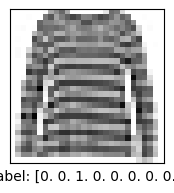

In [9]:
import numpy as np
fig_scale = 0.6

np.set_printoptions(precision=7)
fig, axes = plt.subplots(1, 1, figsize=(2, 2))
sample_id = 4
axes.imshow(Xf_test[sample_id].reshape(28, 28), cmap=plt.cm.gray_r)
axes.set_xlabel("True label: {}".format(yf_test[sample_id]))
axes.set_xticks([])
axes.set_yticks([])
print(network.predict(Xf_test, verbose=0)[sample_id])

In [10]:
test_loss, test_acc = network.evaluate(Xf_test, yf_test, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.8745999932289124


## Model selection
* How many epochs do we need for training?
* Train the neural net and track the loss after every iteration on a validation set
    * You can add a callback to the fit version to get info on every epoch
* Best model after a few epochs, then starts overfitting

In [11]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output


# For plotting the learning curve in real time
class TrainingPlot(Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))

        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))

            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(8, 3))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label="train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label="train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label="val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label="val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #", fontsize=18 * fig_scale)
            plt.ylabel("Loss/Accuracy", fontsize=18 * fig_scale)
            plt.legend(prop={'size': 15 * fig_scale})
            plt.tick_params(axis='both', labelsize=16 * fig_scale)
            plt.show()

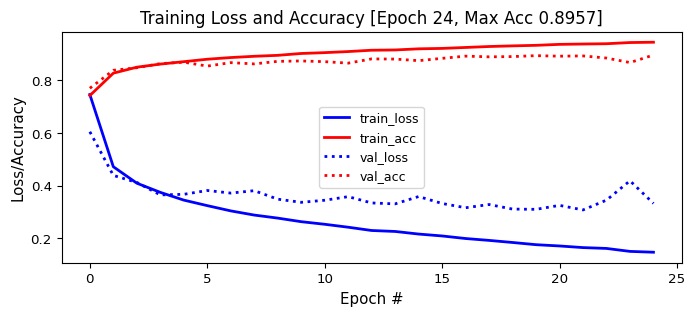

In [12]:
from sklearn.model_selection import train_test_split

x_val, partial_x_train = Xf_train[:10000], Xf_train[10000:]
y_val, partial_y_train = yf_train[:10000], yf_train[10000:]
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=25, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses])

### Early stopping
* Stop training when the validation loss (or validation accuracy) no longer improves
* Loss can be bumpy: use a moving average or wait for $k$ steps without improvement

``` python
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs=25, batch_size=512, callbacks=[earlystop])
```

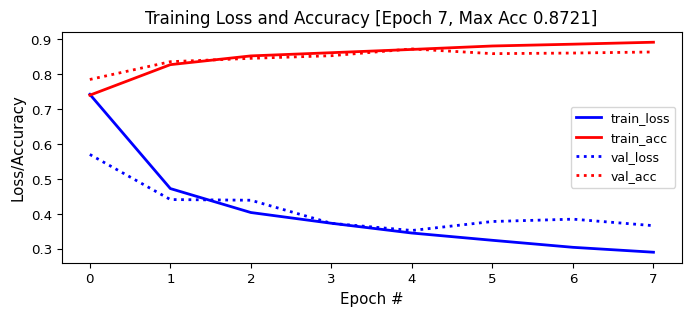

In [13]:
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=25, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop])

### Regularization and memorization capacity
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - Too high capacity causes overfitting, too low causes underfitting
    - In the extreme, the training set can be 'memorized' in the weights
* Smaller models are forced it to learn a compressed representation that generalizes better
    - Find the sweet spot: e.g. start with few parameters, increase until overfitting stars.
* Example: 256 nodes in first layer, 32 nodes in second layer, similar performance

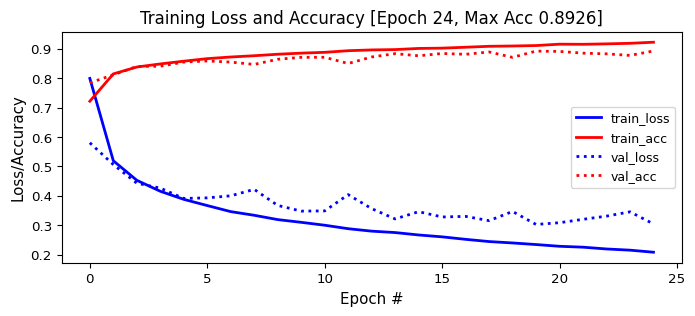

In [14]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
earlystop5 = callbacks.EarlyStopping(monitor='val_loss', patience=5)
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=30, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop5])

#### Information bottleneck
* If a layer is too narrow, it will lose information that can never be recovered by subsequent layers
* _Information bottleneck_ theory defines a bound on the capacity of the network
* Imagine that you need to learn 10 outputs (e.g. classes) and your hidden layer has 2 nodes
    * This is like trying to learn 10 hyperplanes from a 2-dimensional representation
* Example: bottleneck of 2 nodes, no overfitting, much higher training loss 

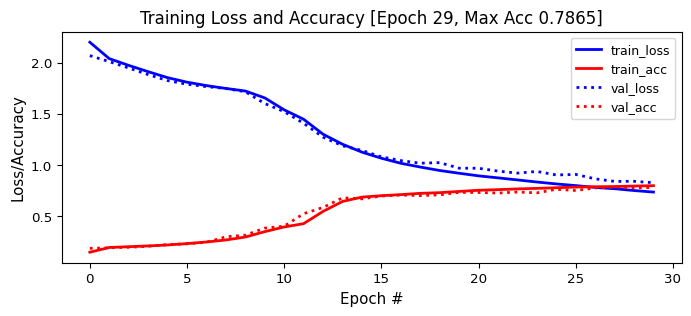

In [15]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
network.add(layers.Dense(2, activation='relu', kernel_initializer='he_normal'))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
earlystop5 = callbacks.EarlyStopping(monitor='val_loss', patience=5)
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=30, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop5])

#### Weight regularization (weight decay)
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights

``` python
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(28 * 28,)))
network.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
```

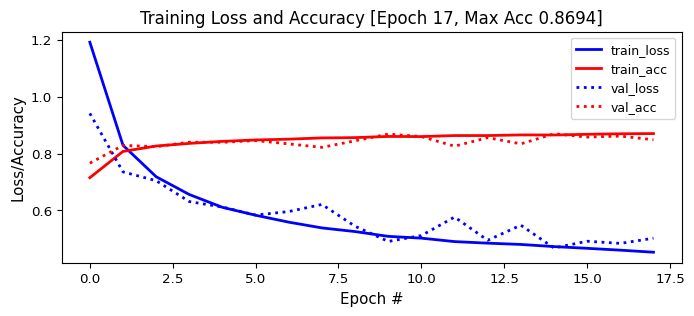

In [ ]:
from tensorflow.keras import regularizers

network = models.Sequential()
network.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(28 * 28,)))
network.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
earlystop5 = callbacks.EarlyStopping(monitor='val_loss', patience=5)
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop5])

### Dropout
* Every iteration, randomly set a number of activations $a_i$ to 0
* _Dropout rate_ : fraction of the outputs that are zeroed-out (e.g. 0.1 - 0.5)
* Idea: break up accidental non-significant learned patterns 
* At test time, nothing is dropped out, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training

In [ ]:
def draw_neural_net(ax, layer_sizes, draw_bias=False, labels=False, activation=False, sigmoid=False,
                    weight_count=False, random_weights=False, show_activations=False, figsize=(4, 4)):
    """
    Draws a dense neural net for educational purposes
    Parameters:
        ax: plot axis
        layer_sizes: array with the sizes of every layer
        draw_bias: whether to draw bias nodes
        labels: whether to draw labels for the weights and nodes
        activation: whether to show the activation function inside the nodes
        sigmoid: whether the last activation function is a sigmoid
        weight_count: whether to show the number of weights and biases
        random_weights: whether to show random weights as colored lines
        show_activations: whether to show a variable for the node activations
        scale_ratio: ratio of the plot dimensions, e.g. 3/4
    """
    figsize = (figsize[0]*fig_scale, figsize[1]*fig_scale)
    left, right, bottom, top = 0.1, 0.89*figsize[0]/figsize[1], 0.1, 0.89
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    colors = ['greenyellow','cornflowerblue','lightcoral']
    w_count, b_count = 0, 0
    ax.set_xlim(0, figsize[0]/figsize[1])
    ax.axis('off')
    ax.set_aspect('equal')
    txtargs = {"fontsize":12*fig_scale, "verticalalignment":'center', "horizontalalignment":'center', "zorder":5}

    # Draw biases by adding a node to every layer except the last one
    if draw_bias:
        layer_sizes = [x+1 for x in layer_sizes]
        layer_sizes[-1] = layer_sizes[-1] - 1

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        node_size = v_spacing/len(layer_sizes) if activation and n!=0 else v_spacing/3.
        if n==0:
            color = colors[0]
        elif n==len(layer_sizes)-1:
            color = colors[2]
        else:
            color = colors[1]
        for m in range(layer_size):
            ax.add_artist(plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), radius=node_size,
                                     color=color, ec='k', zorder=4, linewidth=fig_scale))
            b_count += 1
            nx, ny = n*h_spacing + left, layer_top - m*v_spacing
            nsx, nsy = [n*h_spacing + left,n*h_spacing + left], [layer_top - m*v_spacing - 0.5*node_size*2,layer_top - m*v_spacing + 0.5*node_size*2]
            if draw_bias and m==0 and n<len(layer_sizes)-1:
                ax.text(nx, ny, r'$1$', **txtargs)
            elif labels and n==0:
                ax.text(n*h_spacing + left,layer_top + v_spacing/1.5, 'input', **txtargs)
                ax.text(nx, ny, r'$x_{}$'.format(m), **txtargs)
            elif labels and n==len(layer_sizes)-1:
                if activation:
                    if sigmoid:
                        ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z \;\;\; \sigma$", **txtargs)
                    else:
                        ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z_{} \;\; g$".format(m), **txtargs)
                    ax.add_artist(plt.Line2D(nsx, nsy, c='k', zorder=6))
                    if show_activations:
                        ax.text(n*h_spacing + left + 1.5*node_size,layer_top - m*v_spacing, r"$\hat{y}$", fontsize=12*fig_scale,
                                verticalalignment='center', horizontalalignment='left', zorder=5, c='r')

                else:
                    ax.text(nx, ny, r'$o_{}$'.format(m), **txtargs)
                ax.text(n*h_spacing + left,layer_top + v_spacing, 'output', **txtargs)
            elif labels:
                if activation:
                    ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z_{} \;\; f$".format(m), **txtargs)
                    ax.add_artist(plt.Line2D(nsx, nsy, c='k', zorder=6))
                    if show_activations:
                        ax.text(n*h_spacing + left + node_size*1.2 ,layer_top - m*v_spacing, r"$a_{}$".format(m), fontsize=12*fig_scale,
                                verticalalignment='center', horizontalalignment='left', zorder=5, c='b')
                else:
                    ax.text(nx, ny, r'$h_{}$'.format(m), **txtargs)


    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                if not (draw_bias and o==0 and len(layer_sizes)>2 and n<layer_size_b-1):
                    xs = [n*h_spacing + left, (n + 1)*h_spacing + left]
                    ys = [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing]
                    color = 'k' if not random_weights else plt.cm.bwr(np.random.random())
                    ax.add_artist(plt.Line2D(xs, ys, c=color, alpha=0.6))
                    if not (draw_bias and m==0):
                        w_count += 1
                    if labels and not random_weights:
                        wl = r'$w_{{{},{}}}$'.format(m,o) if layer_size_b>1 else r'$w_{}$'.format(m)
                        ax.text(xs[0]+np.diff(xs)/2, np.mean(ys)-np.diff(ys)/9, wl, ha='center', va='center',
                                fontsize=12*fig_scale)
    # Count
    if weight_count:
        b_count = b_count - layer_sizes[0]
        if draw_bias:
            b_count = b_count - (len(layer_sizes) - 2)
        ax.text(right*1.05, bottom, "{} weights, {} biases".format(w_count, b_count), ha='center', va='center')

In [ ]:
fig = plt.figure(figsize=(4 * fig_scale, 4 * fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1], draw_bias=True, labels=True,
                show_activations=True, activation=True)

#### Dropout layers
* Dropout is usually implemented as a special layer

``` python
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(10, activation='softmax'))
```

In [ ]:
network = models.Sequential()
network.add(layers.Dense(256, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dropout(0.3))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dropout(0.3))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses])

#### Batch Normalization
* We've seen that scaling the input is important, but what if layer activations become very large? 
    * Same problems, starting deeper in the network
* Batch normalization: normalize the activations of the previous layer within each batch
    * Within a batch, set the mean activation close to 0 and the standard deviation close to 1
        * Across badges, use exponential moving average of batch-wise mean and variance
    * Allows deeper networks less prone to vanishing or exploding gradients

``` python
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
```

```python

```


In [ ]:
network = models.Sequential()
network.add(layers.Dense(265, activation='relu', input_shape=(28 * 28,)))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(partial_x_train, partial_y_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses])

### Tuning multiple hyperparameters
* You can wrap Keras models as scikit-learn models and use any tuning technique
* Keras also has built-in RandomSearch (and HyperBand and BayesianOptimization - see later)

```python
def make_model(hp):
    m.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    m.compile(optimizer=Adam(hp.Choice('learning rate', [1e-2, 1e-3, 1e-4])))
    return model
```

```python
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
clf = KerasClassifier(make_model)
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)

from kerastuner.tuners import RandomSearch
tuner = keras.RandomSearch(build_model, max_trials=5)
```

## Summary

* Neural architectures
* Training neural nets
    * Forward pass: Tensor operations
    * Backward pass: Backpropagation
* Neural network design:
    * Activation functions
    * Weight initialization
    * Optimizers
* Neural networks in practice
* Model selection
    * Early stopping
    * Memorization capacity and information bottleneck
    * L1/L2 regularization
    * Dropout
    * Batch normalization